---

Author: **`Crispen Gari`**

Topic: **`"Multimodal entailment" (NER)`**

Main: **`Natural Language Processing NLP`**

Library: **`TensorFlow (2.x)`**

Programing Language: **`Python`**

Date: **`2021-09-21`**

---

### Multimodal entailment

In this notebooke we are going to follow up the [keras](https://keras.io/examples/nlp/multimodal_entailment/) and create a model for predicting multimodal entailment suing the [ multimodal entailment dataset](https://github.com/google-research-datasets/recognizing-multimodal-entailment) by Google.


### Definition

On social media platforms, to audit and moderate content we may want to find answers to the following questions in near real-time:

1. **_Does a given piece of information contradict the other?_**
2. **_Does a given piece of information imply the other?_**

This is the art of analysing _textual entailment_, however this is the case when the ifomation is comming from text only.

In real word information can come from different sources for example from images, videos, audios not just text. **Multimodal entailment** will come into play in this senario because it is the extension of text entailment.

### Textual Entailment
This is the art of analying textual content.

### Requirements

* `tensorflow_text`


In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.4 MB 5.5 MB/s 



2. `tensorflow_hub`

In [2]:
!pip install -q tensorflow_hub

### Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as text
import tensorflow_hub as hub

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tf.__version__

'2.6.0'

### Data

The original dataset is available [here](https://github.com/google-research-datasets/recognizing-multimodal-entailment). It comes with URLs of images which are hosted on Twitter's photo storage system called the [Photo Blob Storage (PBS for short)](https://blog.twitter.com/engineering/en_us/a/2012/blobstore-twitter-s-in-house-photo-storage-system). We will be working with the downloaded images along with additional data that comes with the original dataset.

In [ ]:
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

### Reading the data.

In [5]:
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.head()

,id_1,text_1,image_1,id_2,text_2,image_2,label
0,1375936088968200205,"150 years after its inauguration, the strategi...",http://pbs.twimg.com/media/ExeIVRBWYAAwizQ.jpg,1376653595144241155,Look how only 190 km #suezcanel carries 12% of...,http://pbs.twimg.com/media/ExrbJffWgAoBaxO.jpg,NoEntailment
1,1360981123388436489,Fall Guys is celebrating Valentine's Day with ...,http://pbs.twimg.com/media/EuMowPiXYAEylR8.jpg,1361075903606910976,Fall Guys Red Panda costume available for limi...,http://pbs.twimg.com/media/EuODUixWYAMRukK.jpg,NoEntailment
2,1336637206899945472,Impressive Batting Display From Shoaib Malik 🏏...,http://pbs.twimg.com/media/EoywcVGXMAE5FZK.jpg,1339243901799030785,"A Half century of King\n\n 🔥""Shoaib Malik"" ...",http://pbs.twimg.com/media/EpXzOwRXYAYLaCB.jpg,NoEntailment
3,1336490796279742464,How #confident are you today? https://t.co/5ay...,http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg,1341081069248868353,How #confident are you today? https://t.co/KqZ...,http://pbs.twimg.com/media/Epx6IA-UwAA8pqN.jpg,Implies
4,1358934899256877059,The Peacocks finish out the first quarter trai...,http://pbs.twimg.com/media/EtvoCsuWQAALmyP.jpg,1361131487077228546,10 minutes gone here at home as the Peacocks l...,http://pbs.twimg.com/media/EuO1xf2XIAAOIGb.jpg,NoEntailment


The columns that we are interested in in this dataframe are:

1. text_1
2. image_1
3. text_2
4. image_2
5. label


### Custom labels


In [6]:
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

### Vocabulary

> **entail**- _involve (something) as a necessary or inevitable part or consequence._

### The formular for the task is as follows:

```
Given the pairs of (text_1, image_1) and (text_2, image_2) do they entail (or not entail or contradict) each other?
```

We have the images already downloaded. `image_1` is downloaded as id1 as its filename and `image2` is downloaded as id2 as its filename. In the next step, we will add two more columns to df - filepaths of `image_1s` and `image_2s`.

In [10]:
images_one_paths = []
images_two_paths = []

for index in range(len(df)):
  current_row = df.iloc[index]
  id_1 = current_row["id_1"]
  id_2 = current_row["id_2"]
  extentsion_one = current_row.image_1.split(".")[-1]
  extentsion_two = current_row.image_2.split(".")[-1]

  image_one_path = os.path.join(
      image_base_path, f"{str(id_1)}.{extentsion_one}"
  )
  image_two_path = os.path.join(
      image_base_path, f"{str(id_2)}.{extentsion_two}"
  )

  images_one_paths.append(image_one_path)
  images_two_paths.append(image_two_path)


df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

df["label_index"] = df.label.apply(lambda x: label_map[x])

df.head()

,id_1,text_1,image_1,id_2,text_2,image_2,label,image_1_path,image_2_path,label_index
0,1375936088968200205,"150 years after its inauguration, the strategi...",http://pbs.twimg.com/media/ExeIVRBWYAAwizQ.jpg,1376653595144241155,Look how only 190 km #suezcanel carries 12% of...,http://pbs.twimg.com/media/ExrbJffWgAoBaxO.jpg,NoEntailment,/root/.keras/datasets/tweet_images/13759360889...,/root/.keras/datasets/tweet_images/13766535951...,2
1,1360981123388436489,Fall Guys is celebrating Valentine's Day with ...,http://pbs.twimg.com/media/EuMowPiXYAEylR8.jpg,1361075903606910976,Fall Guys Red Panda costume available for limi...,http://pbs.twimg.com/media/EuODUixWYAMRukK.jpg,NoEntailment,/root/.keras/datasets/tweet_images/13609811233...,/root/.keras/datasets/tweet_images/13610759036...,2
2,1336637206899945472,Impressive Batting Display From Shoaib Malik 🏏...,http://pbs.twimg.com/media/EoywcVGXMAE5FZK.jpg,1339243901799030785,"A Half century of King\n\n 🔥""Shoaib Malik"" ...",http://pbs.twimg.com/media/EpXzOwRXYAYLaCB.jpg,NoEntailment,/root/.keras/datasets/tweet_images/13366372068...,/root/.keras/datasets/tweet_images/13392439017...,2
3,1336490796279742464,How #confident are you today? https://t.co/5ay...,http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg,1341081069248868353,How #confident are you today? https://t.co/KqZ...,http://pbs.twimg.com/media/Epx6IA-UwAA8pqN.jpg,Implies,/root/.keras/datasets/tweet_images/13364907962...,/root/.keras/datasets/tweet_images/13410810692...,1
4,1358934899256877059,The Peacocks finish out the first quarter trai...,http://pbs.twimg.com/media/EtvoCsuWQAALmyP.jpg,1361131487077228546,10 minutes gone here at home as the Peacocks l...,http://pbs.twimg.com/media/EuO1xf2XIAAOIGb.jpg,NoEntailment,/root/.keras/datasets/tweet_images/13589348992...,/root/.keras/datasets/tweet_images/13611314870...,2


### Dataset visualization

In [11]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")


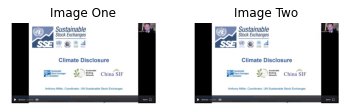

Text one: Environmental risks have become unneglectable risks for financial institutions. 

Watch SSE presentation at the Environmental Risk Management and Climate Exposure Reporting Webinar 

👉https://t.co/54D3njX8iT https://t.co/VQC3uLX0CS
Text two: Environmental risks have become unneglectable risks for financial institutions. 

Watch SSE presentation at the Environmental Risk Management and Climate Exposure Reporting Webinar 

👉https://t.co/54D3njFwUj https://t.co/J6DKKwv36v
Label: NoEntailment


In [14]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

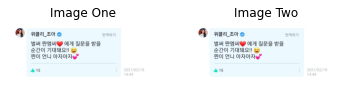

Text one: 210219 COMMENT
💬 Have you ever imagined about being questioned by MC Jihan?

#Zoa
I'm already excited to get a question from MC Jjyan❤️ !! 😆
Jjyan unnie you can do it💕

#Weeekly #위클리 #조아 @_Weeekly https://t.co/wwy8pzREZ6
Text two: 210219 COMMENT
💬 I want to see Jihan introducing Weeekly on The Show and the appearance of Leader Puppy (Soojin) when doing the interview

#LeeSoojin
Thinking about how Jihan would introducing Weeekly already make me overwhelmed (of joy)..💦 
So cool... 👍 Our jjyanie...🍒 https://t.co/v2yBsNhGXp
Label: NoEntailment


In [13]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

### Splitting the sets

There's a class inbalance problem in our dataset. Let's chech how many examples do we have for each label.

In [15]:
df.label.value_counts()

NoEntailment     1182
Contradictory     109
Implies           109
Name: label, dtype: int64

To solve this issue we are going to use the **stratified split**.

In [20]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")


Total training examples: 1197
Total validation examples: 63
Total test examples: 140


### Data input pipeline
We are going to ues the [BERT](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub) model provided by tensorflow hub.

To keep the runtime of this example relatively short, we will use a smaller variant of the original BERT model.

In [21]:
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


The most of the text preprocessing code comes from [this](https://www.tensorflow.org/text/tutorials/bert_glue) tutorial.

In [23]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

    Args:
      sentence_features: A list with the names of string-valued features.
      seq_length: An integer that defines the sequence length of BERT inputs.

    Returns:
      A Keras Model that can be called on a list or dict of string Tensors
      (with the order or names, resp., given by sentence_features) and
      returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, 
                            name=ft) for ft in sentence_features 
  ]

  # Tokenization
  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
  segments = [tokenizer(s) for s in input_segments]
  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments
  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(
      bert_preprocess.bert_pack_inputs,
      arguments=dict(seq_length=seq_length),
      name="packer",
  )
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)



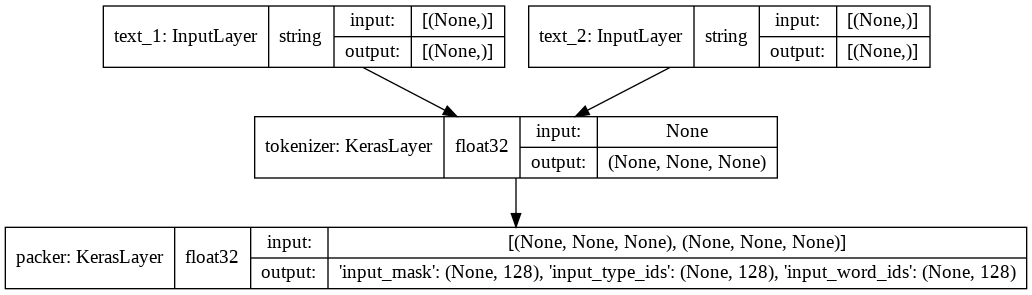

In [24]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1",
                                                       "text_2"])
keras.utils.plot_model(bert_preprocess_model, 
                       show_shapes=True, show_dtype=True)

### Run the preprocessor on a sample input

In [25]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Text 1: Good night! Dream about Saimaki! https://t.co/fK4bPoPLPn
Text 2: I won't leave you too long without something Saimaki https://t.co/mkJ5drlOxJ
Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2204  2305   999  3959  2055 18952  2863  3211   999 16770  1024
  1013  1013  1056  1012], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


### Dataset

We can now create a `tf.data.Dataset` from a dataframe. Note that the text inputs will be preprocessed as a part of the data input pipeline. But the preprocessing modules can also be a part of their corresponding BERT models. This helps reduce the training/serving skew and lets our models operate with raw text inputs. 

In [26]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_index"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_index")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

### Preprocessing utilities

In [27]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [28]:
def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

In [29]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Model building utilities

Our final model will accept two images along with their text counterparts. While the images will be directly fed to the model the text inputs will first be preprocessed and then will make it into the model. Below is a visual illustration of this approach:

![img](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/figures/brief_architecture.png)

Projection utilities

In [30]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

Vision utils

In [31]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

Text encoder utils

In [32]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

Multimodal model utilities

94683136/94668760 [==============================] - 1s 0us/step


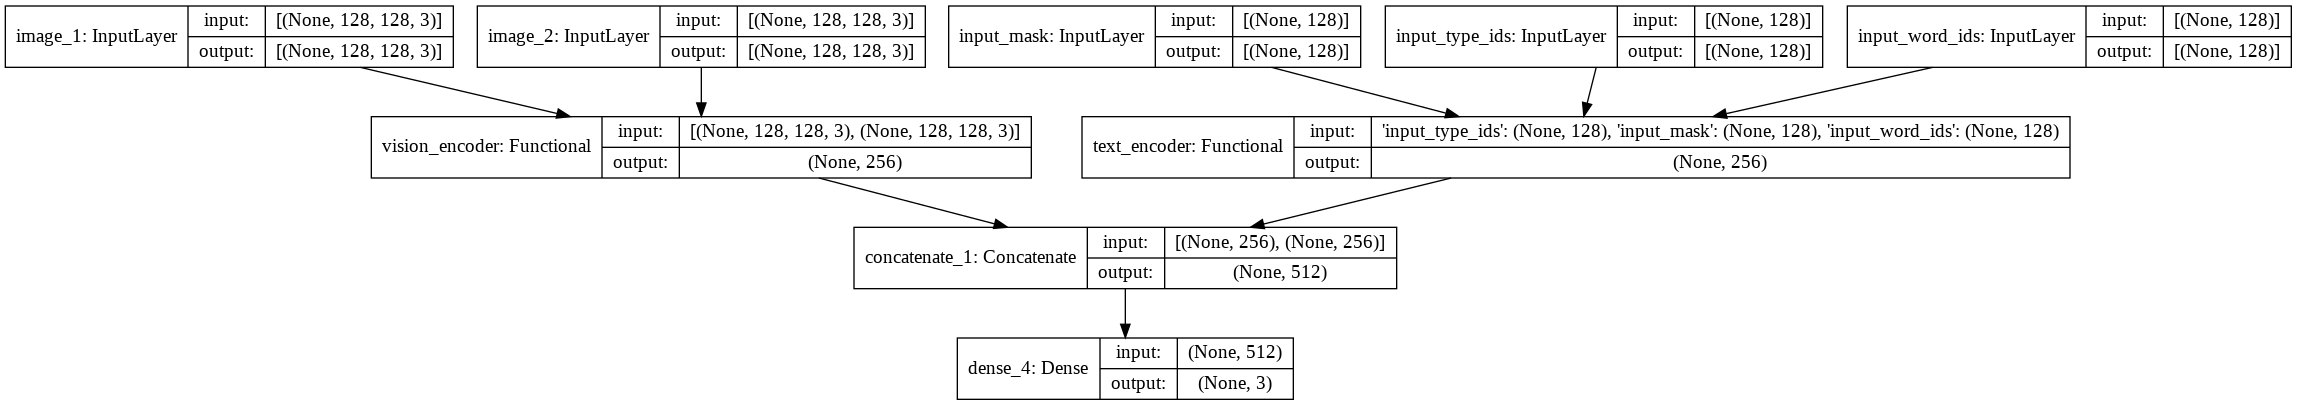

In [33]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

### Training the model

In [34]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
38/38 [==============================] - 72s 784ms/step - loss: 0.8933 - accuracy: 0.8279 - val_loss: 0.5667 - val_accuracy: 0.8413
Epoch 2/10
38/38 [==============================] - 9s 230ms/step - loss: 0.3902 - accuracy: 0.8805 - val_loss: 0.5747 - val_accuracy: 0.8571
Epoch 3/10
38/38 [==============================] - 9s 232ms/step - loss: 0.3120 - accuracy: 0.8947 - val_loss: 0.6446 - val_accuracy: 0.8571
Epoch 4/10
38/38 [==============================] - 9s 230ms/step - loss: 0.2052 - accuracy: 0.9315 - val_loss: 0.9708 - val_accuracy: 0.8254
Epoch 5/10
38/38 [==============================] - 9s 234ms/step - loss: 0.1276 - accuracy: 0.9599 - val_loss: 1.1640 - val_accuracy: 0.8571
Epoch 6/10
38/38 [==============================] - 9s 233ms/step - loss: 0.1307 - accuracy: 0.9499 - val_loss: 1.2230 - val_accuracy: 0.8254
Epoch 7/10
38/38 [==============================] - 9s 234ms/step - loss: 0.1984 - accuracy: 0.9365 - val_loss: 1.3224 - val_accuracy: 0.8254
Epoch

### Model evaluation

In [35]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 6s 810ms/step - loss: 1.2514 - accuracy: 0.8786
Accuracy on the test set: 87.86%.


### Credits

* [keras tutorials](https://keras.io/examples/nlp/multimodal_entailment/)